In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas
import time, json, requests, pprint, copy, math, dateutil
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh
import scipy.interpolate

def polygon_lon_lat(polygon_str):
    # polygon_str: string value of polygon search parameter, ie "[[lon0,lat0],[lon1,lat1],...,[lon0,lat0]]"
    # convert the polygon shape to lon and lat and save in a dictionary
    polygon_lon_lat_dict = {'lon': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[0::2]], \
                    'lat': [float(i) for i in ((polygon_str.replace('[','')).replace(']','')).split(',')[1::2]]
                   }
    return polygon_lon_lat_dict

def simple_map(longitudes, latitudes, z=None, polygon=None, title='', fig=None, figIndex=None, marker=None, secondaries=None, bounding_box=None):
    if fig:
        ax = fig.add_subplot(figIndex[0], figIndex[1], figIndex[2], projection=ccrs.LambertConformal(cutoff=-60))
    else:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertConformal(cutoff=-60))
    if bounding_box:
        ax.set_extent(bounding_box)
    gl = ax.gridlines(draw_labels=True,color='black')
    if z:
        s = ax.scatter(longitudes, latitudes, c=z, transform=ccrs.PlateCarree())
        plt.colorbar(s, pad=0.1)
    else:
        s = ax.scatter(longitudes, latitudes,transform=ccrs.PlateCarree())
    
    if polygon:
        plt.plot(polygon_lon_lat(polygon)['lon'],polygon_lon_lat(polygon)['lat'],'-k',transform=ccrs.PlateCarree()) 
    if marker:
        plt.plot(marker[0],marker[1],'Xr', transform=ccrs.PlateCarree(), markersize=20)
    if secondaries:
        for sec in secondaries:
            ax.scatter(sec['lon'], sec['lat'],transform=ccrs.PlateCarree(), color='red', marker='x', s=100)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    plt.title(title, fontdict={'fontsize':20})
    
def padlist(ls, length, token=None):
    x = copy.copy(ls)
    x = [float(i) for i in x]
    if len(ls) < length:
        tail = [token]*(length - len(ls))
        x += tail
    return x

def varrange(profiles, var):
    # given a list of profiles and a variable name,
    # return the globally min, max limits of that variable
    
    data = [p['data'] for p in profiles]
    data = [j for sub in data for j in sub]
    data = [level[var] for level in data if var in level]
    return [min(data), max(data)]


# Exploring Argo BGC with Argovis

## Setup: Register an API key

In order to allocate Argovis's limited computing resources fairly, users are encouraged to register and request a free API key. This works like a password that identifies your requests to Argovis. To do so:

 - Visit [https://argovis-keygen.colorado.edu/](https://argovis-keygen.colorado.edu/)
 - Fill out the form under _New Account Registration_
 - An API key will be emailed to you shortly.
 
Treat this API key like a password - don't share it or leave it anywhere public. If you ever forget it or accidentally reveal it to a third party, see the same website above to change or deactivate your token.

Put your API key in the quotes in the variable below before moving on:

In [2]:
API_KEY=''
API_PREFIX = 'https://argovis-api.colorado.edu/'

# Downloading and plotting BGC data

Download all the BGC measurements in a region over a timespan, and put them on a map:

In [3]:
polygon = '[[-75,42],[-75,38],[-62,38],[-62,42],[-75,42]]'
params = {
        'startDate': '2021-01-01T00:00:00Z',
        'endDate': '2022-01-01T00:00:00Z',
        'source': 'argo_bgc',
        'polygon': polygon,
        'data': 'all'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

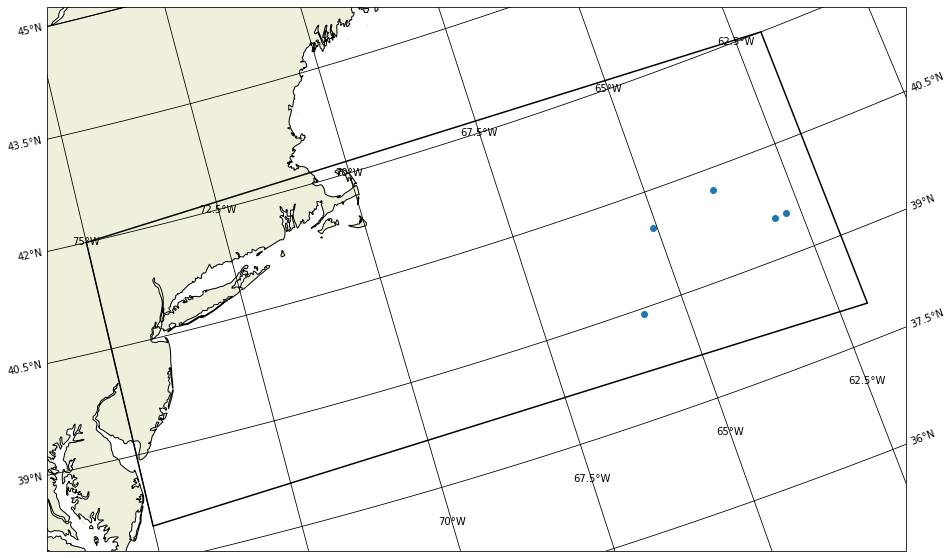

In [4]:
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes,polygon=polygon)

Turn our data into a list of dataframes, and plot with color by QC:

In [5]:
dfs = [pandas.DataFrame.from_records([level for level in profile['data']]) for profile in d]

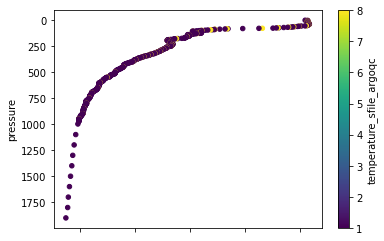

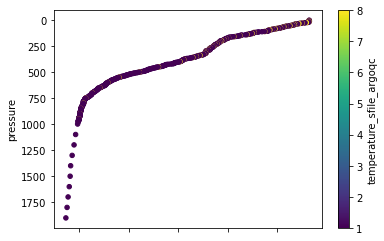

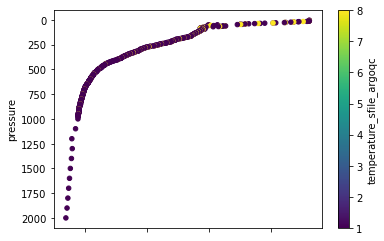

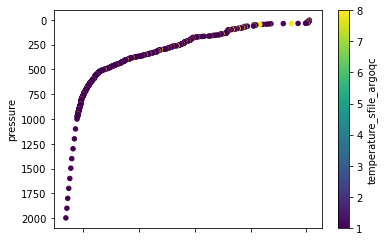

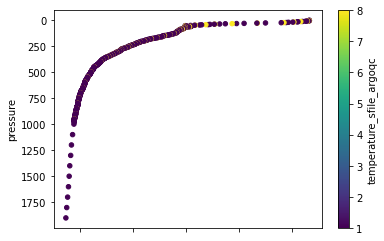

In [6]:
for df in dfs:
    a = df.plot.scatter(x='temperature_sfile', y='pressure', c='temperature_sfile_argoqc', colormap='viridis')
    a.invert_yaxis()

Or, filter by QC before plotting:

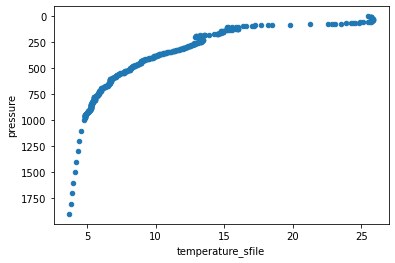

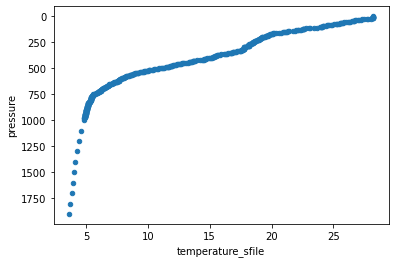

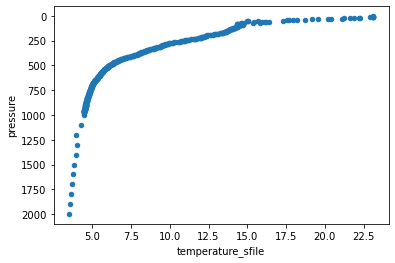

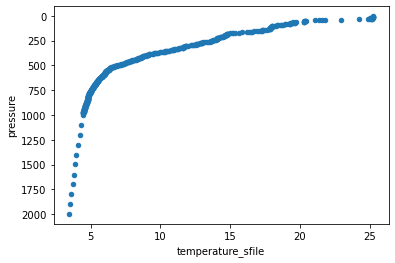

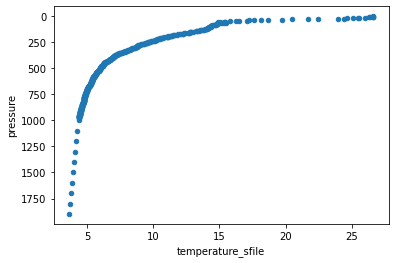

In [7]:
for df in dfs:
    df_qc = df[df['temperature_sfile_argoqc'] == 1]
    a = df_qc.plot.scatter(x='temperature_sfile', y='pressure')
    a.invert_yaxis()

Plot one variable against another:

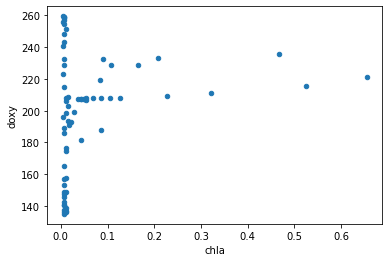

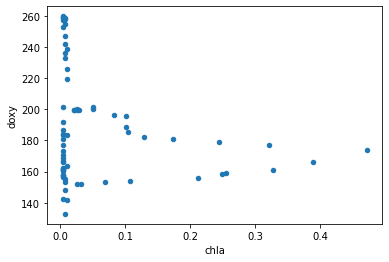

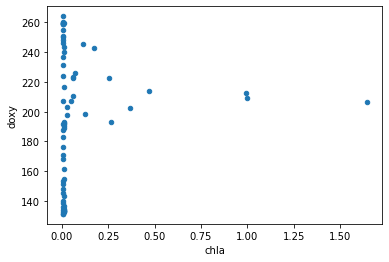

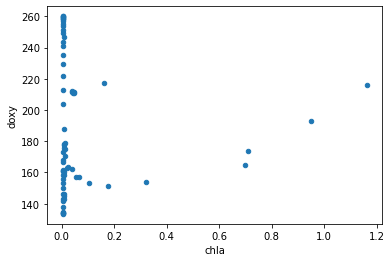

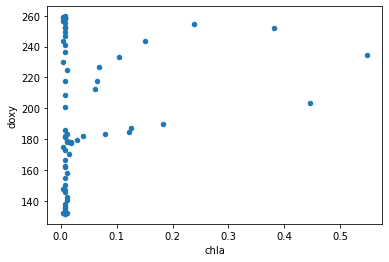

In [8]:
for df in dfs:
    a = df.plot.scatter(x='chla', y='doxy')

List all BGC platforms, with some summary statistics:

In [9]:
bgc = requests.get(API_PREFIX + 'argo/bgc').json()
bgc

[{'_id': 'argo_bgc',
  'summary': [{'_id': '6901770',
    'n': 194,
    'mostrecent': '2018-06-14T09:37:00.000Z'},
   {'_id': '5904598', 'n': 249, 'mostrecent': '2020-02-02T16:39:15.001Z'},
   {'_id': '6902547', 'n': 368, 'mostrecent': '2016-05-11T11:59:00.000Z'},
   {'_id': '5903714', 'n': 281, 'mostrecent': '2016-02-12T11:47:40.001Z'},
   {'_id': '6902886', 'n': 82, 'mostrecent': '2022-11-04T23:03:59.999Z'},
   {'_id': '2903395', 'n': 171, 'mostrecent': '2021-06-24T13:36:44.000Z'},
   {'_id': '6903093', 'n': 125, 'mostrecent': '2022-11-08T17:39:30.000Z'},
   {'_id': '2901042', 'n': 62, 'mostrecent': '2011-05-07T14:29:38.000Z'},
   {'_id': '3902471', 'n': 5, 'mostrecent': '2022-11-10T07:35:03.029Z'},
   {'_id': '6902801', 'n': 20, 'mostrecent': '2017-10-05T06:11:00.000Z'},
   {'_id': '6903128', 'n': 37, 'mostrecent': '2022-11-04T14:39:00.000Z'},
   {'_id': '5905229', 'n': 2, 'mostrecent': '2019-01-08T08:23:28.000Z'},
   {'_id': '6903577', 'n': 222, 'mostrecent': '2022-11-10T11:15:00.0

Plot map of all bgc platforms (notes asked for 'color coded by WMO' - not sure this makes sense, in a 10 day span, which is all that's reasonable for a global plot, these colors will all just be different, which doesn't really add anything):

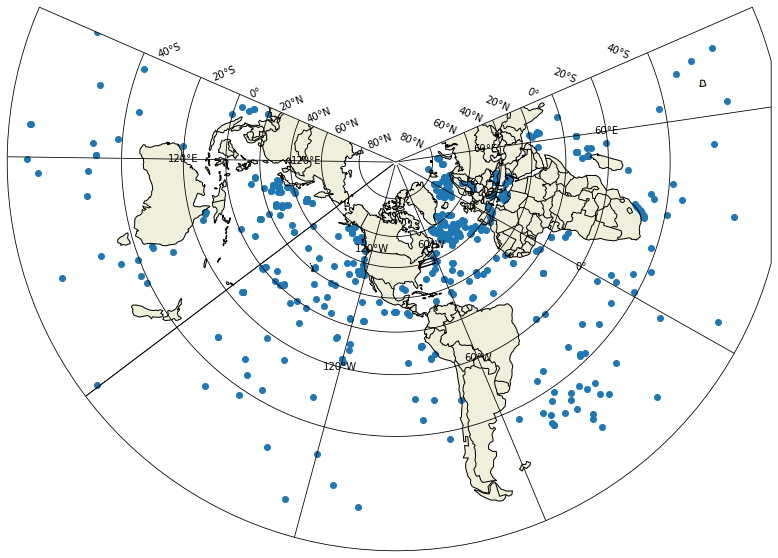

In [10]:
params = {
        'startDate': '2022-10-31T00:00:00Z',
        'endDate': '2022-11-11T00:00:00Z',
        'source': 'argo_bgc',
        'compression': 'array'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)
longitudes = [x['geolocation']['coordinates'][0] for x in d]
latitudes  = [x['geolocation']['coordinates'][1] for x in d]

simple_map(longitudes,latitudes,polygon=polygon)

Query what variables are available for a certain platform

In [11]:
params = {
       'platform': '6902740'
    }

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [12]:
variables = set({})
for i in range(len(d)):
    if 'data_keys' in d[i]:
        variables.update(d[i]['data_keys'])
print(variables)

{'doxy', 'salinity_sfile', 'down_irradiance490', 'cdom_argoqc', 'chla', 'temperature', 'temperature_sfile_argoqc', 'chla_argoqc', 'downwelling_par', 'down_irradiance412_argoqc', 'down_irradiance490_argoqc', 'doxy_argoqc', 'down_irradiance380', 'bbp700_argoqc', 'downwelling_par_argoqc', 'temperature_sfile', 'down_irradiance412', 'salinity_sfile_argoqc', 'pressure_argoqc', 'salinity_argoqc', 'salinity', 'bbp700', 'down_irradiance380_argoqc', 'cdom', 'temperature_argoqc', 'pressure'}


Query platform and plot data for variable of interest
Include shaded plots (time vs pressure) too (after interpolation on regular vertical grid)

In [13]:
params = {
    'platform': '6902740',
    'data': 'doxy'
}

d = avh.query('argo', options=params, apikey=API_KEY, apiroot=API_PREFIX)

In [14]:
def interpolate(profile, levels):
    # given a <profile> and a list of desired pressure <levels>,
    # return a profile with profile.data levels at the desired pressure levels, with all available data interpolated to match
    # drop all QC and note `data_interpolated` in profile.data_warnings
    
    data_names = ['pressure']
    interpolated_data = [levels]
    for key in profile['data_keys']:
        if '_argoqc' not in key and '_woceqc' not in key and key!='pressure':
            finites = [(level['pressure'], level[key]) for level in profile['data'] if level['pressure'] is not None and level[key] is not None and not math.isnan(level['pressure']) and not math.isnan(level[key])]
            pressure = [x[0] for x in finites]
            data = [x[1] for x in finites]
            data_names.append(key)
            levels_in_range = [x for x in levels if x<pressure[-1]]
            interpolated_data.append(padlist(scipy.interpolate.pchip_interpolate(pressure, data, levels_in_range), len(levels), 0 ) )
    
    interpolated_levels = list(zip(*interpolated_data))
    data = [{data_names[i]:d[i] for i in range(len(data_names))} for d in interpolated_levels]
    interpolated_profile = copy.deepcopy(profile) # don't mutate the original
    interpolated_profile['data'] = data
    if 'data_warnings' in interpolated_profile:
        interpolated_profile['data_warnings'].append('data_interpolated')
    else:
        interpolated_profile['data_warnings'] = ['data_interpolated']
    return interpolated_profile

In [15]:
def argo_heatmap(profiles, variable, interp_levels):
    interpolated_profiles = [interpolate(p,interp_levels) for p in profiles]
    timestamps = [dateutil.parser.isoparse(p['timestamp']) for p in interpolated_profiles]
    
    # pcolormesh needs arrays of bin boundaries; use the x,y values as the lower bound like a histogram, 
    # and set the final upper bound to make a bin the same width as previous bin
    level_bounds = copy.copy(interp_levels)
    level_bounds.append(interp_levels[-1] + interp_levels[-1] - interp_levels[-2])
    time_bounds = copy.copy(timestamps)
    time_bounds.append(timestamps[-1] + (timestamps[-1] - timestamps[-2]) )
    
    # shape variable into something appropriate
    data = [x['data'] for x in interpolated_profiles]
    data = [[level[variable] for level in x] for x in data]
    data = np.transpose(data)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    pcm = ax.pcolormesh(time_bounds, level_bounds, data, vmin=varrange(d,variable)[0], vmax=varrange(d,variable)[1])
    ax.invert_yaxis()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Pressure [mbar]')
    fig.colorbar(pcm, label=variable + ' [' + d[0]['units'][variable]+']')
    type(ax)

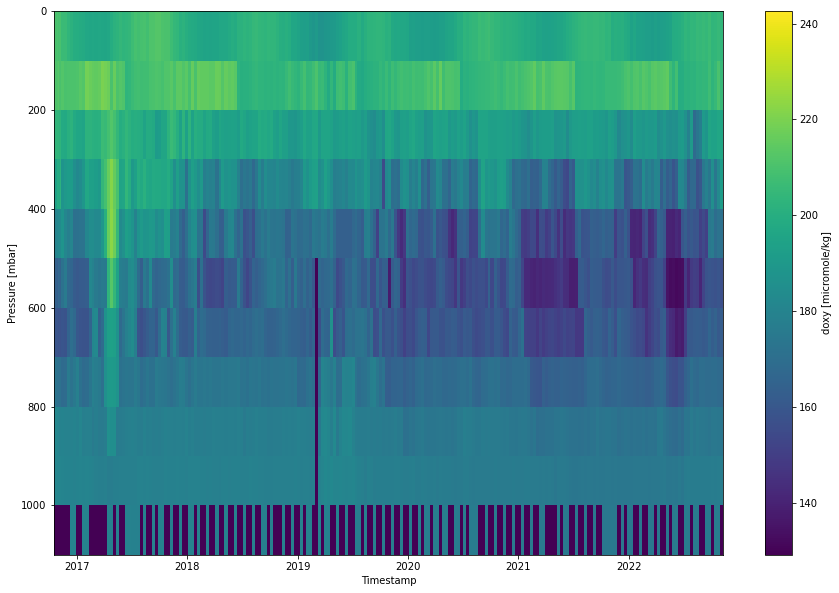

In [16]:
argo_heatmap(d, 'doxy', list(range(0,1001))[0::100])

# Colocating BGC profiles with other data

We can co-locate Argo BGC profiles with other measurements and phenomena, like tropical cyclones. For example, let's find all the BGC profiles near hurricane Maria in 2017, and plot some BGC measurements before and after the hurricane passed:

In [17]:
tc_param = {
    'startDate': '2017-09-01T00:00:00Z',
    'endDate': '2017-10-01T00:00:00Z',
    'name': 'MARIA',
    'data': 'wind,surface_pressure'
}

tc = avh.query('tc', options=tc_param, apikey=API_KEY, apiroot=API_PREFIX)

In [18]:
argo_bgc = []

for h in tc:
    colo_argo = {
        'center': str(h['geolocation']['coordinates'][0]) + ',' + str(h['geolocation']['coordinates'][1]),
        'radius': 52,
        'startDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=-6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'endDate': (datetime.strptime(h['timestamp'], "%Y-%m-%dT%H:%M:%S.%fZ") + timedelta(days=6)).strftime("%Y-%m-%dT%H:%M:%SZ"),
        'data': 'all',
        'source': 'argo_bgc',
        'compression': 'array'
    }
    p = avh.query('argo', options=colo_argo, apikey=API_KEY, apiroot=API_PREFIX)

    if len(p) == 0:
        argo_bgc.append(None)
    else:
        print('Profile found adjacent to', h['geolocation']['coordinates'][0], h['geolocation']['coordinates'][1])
        argo_bgc.append(p)

Profile found adjacent to -70.9 21.9
Profile found adjacent to -70.5 21.2
Profile found adjacent to -70 20.8


['bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_argoqc', 'chla', 'chla_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_argoqc', 'temperature', 'temperature_argoqc', 'temperature_sfile', 'temperature_sfile_argoqc']
['bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_argoqc', 'chla', 'chla_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_argoqc', 'temperature', 'temperature_argoqc', 'temperature_sfile', 'temperature_sfile_argoqc']
['bbp532', 'bbp532_a

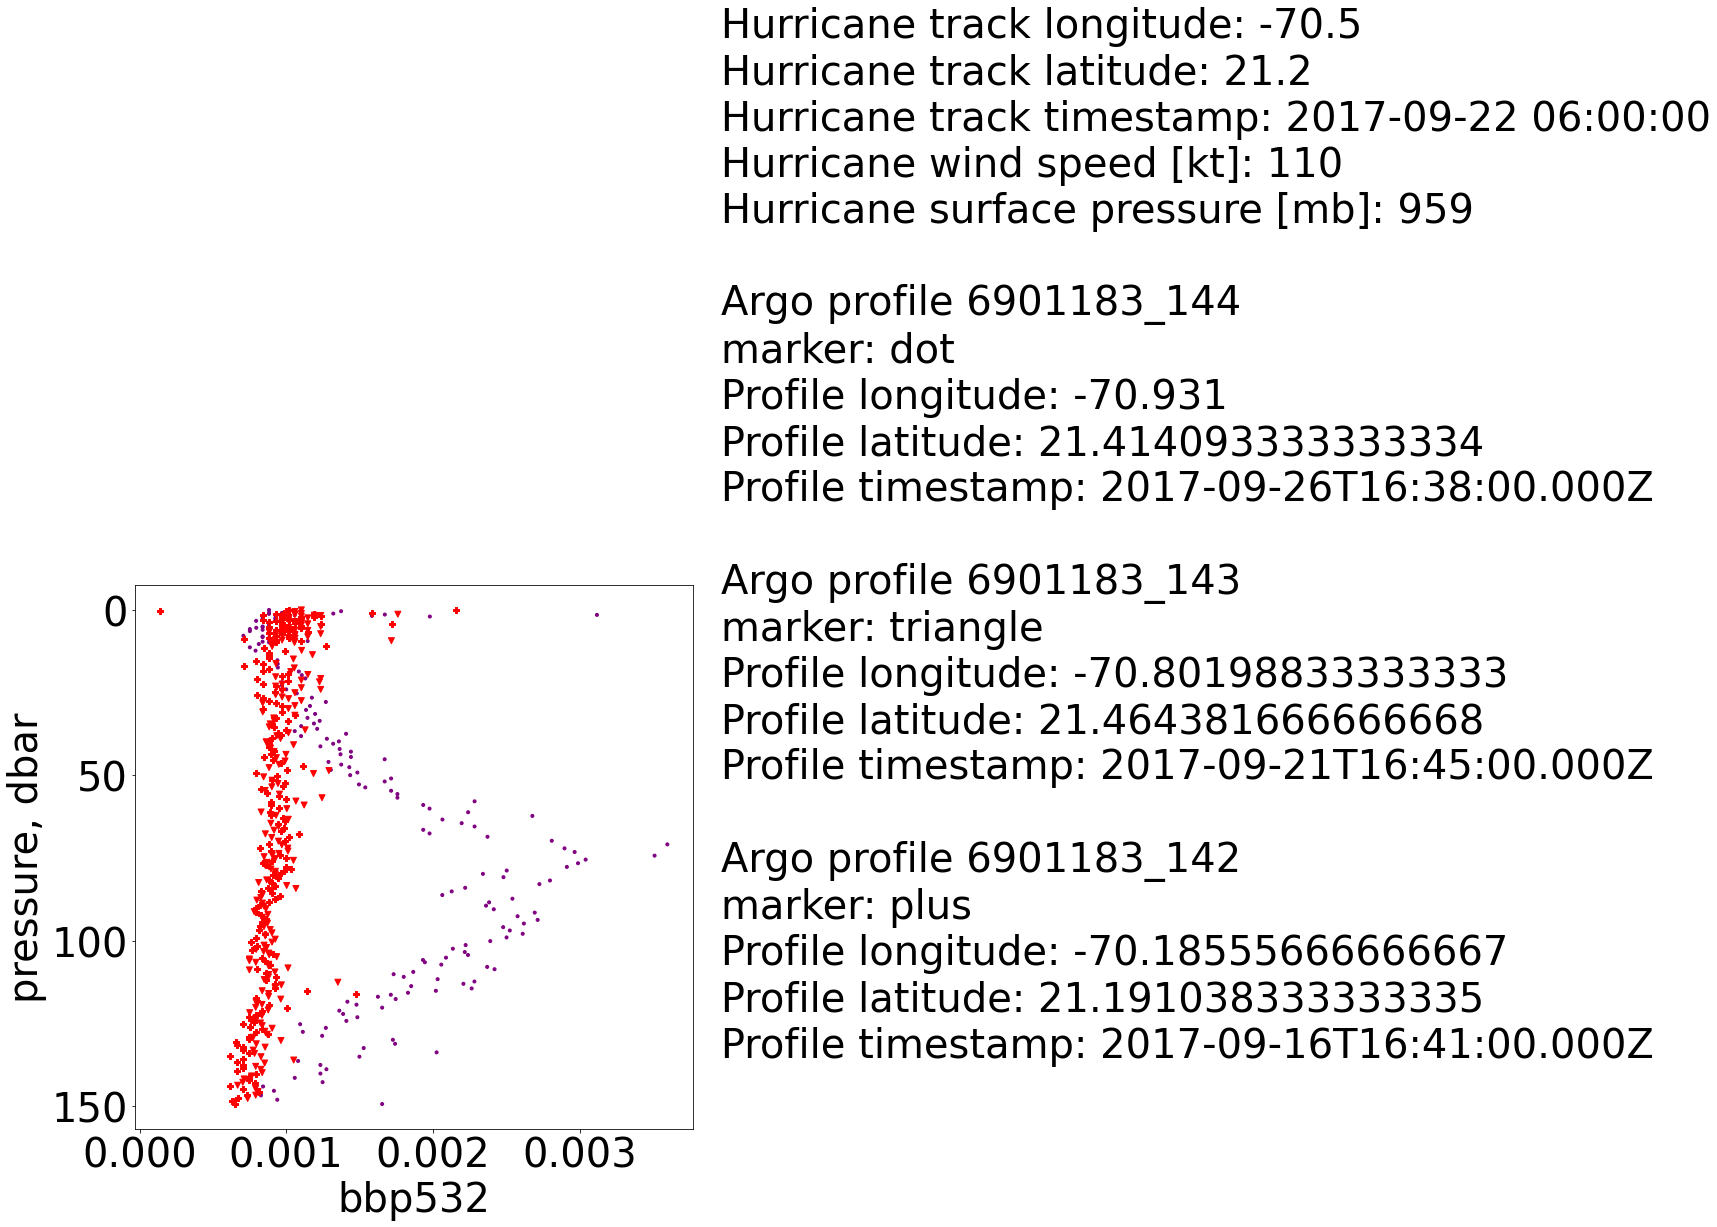

In [19]:
floats = []
colorBefore = 'red'
colorAfter = 'purple'
bracket_points = []
for i, colo in enumerate(argo_bgc):
    buddyBefore = False
    buddyAfter = False
    if colo:
        hurrtime = avh.parsetime(tc[i]['timestamp']) 
        for p in colo:
            ptime = avh.parsetime(p['timestamp'])
            buddy={
                "lon": p['geolocation']['coordinates'][0],
                "lat": p['geolocation']['coordinates'][1],
            }
            if ptime < hurrtime:
                buddy['color'] = colorBefore
                buddyBefore = True
            else:
                buddy['color'] = colorAfter
                buddyAfter = True
            floats.append(buddy)
        if buddyBefore and buddyAfter:
            bracket_points.append(i)
#simple_map(tc_lon, tc_lat, secondaries=floats, z=tc_wind, zlabel='Wind Speed [kt]')

def hurrplot(bracket_points, var, maxpress=150, line=False):
    markers = ['.', 'v', 'P', 'X']
    markernames = ['dot', 'triangle', 'plus', 'x']
    fnt_sz = 40
    if var == 'temperature':
        var_units = ', deg C'
    elif var == 'salinity':
        var_units = ', psu'
    else:
        var_units = ''
    #fig, axs = plt.subplots(len(bracket_points), figsize=(10,10*len(bracket_points)))
    #n = 0
    for i in bracket_points:
        colo = argo_bgc[i]
        hurrtime = avh.parsetime(tc[i]['timestamp'])
        hurrspeed = tc[i]['data'][0]['wind']
        hurrpress = tc[i]['data'][0]['surface_pressure']
        hurrlon = tc[i]['geolocation']['coordinates'][0]
        hurrlat = tc[i]['geolocation']['coordinates'][1]
        annotation = 'Hurricane track longitude: ' + str(hurrlon) + '\nHurricane track latitude: ' + str(hurrlat) + '\nHurricane track timestamp: ' + str(hurrtime) + '\nHurricane wind speed [kt]: ' + str(hurrspeed) + '\nHurricane surface pressure [mb]: ' + str(hurrpress)
        np = 0
        for p in colo:
            print(p['data_keys'])
            ptime = avh.parsetime(p['timestamp'])
            c = colorBefore
            if ptime > hurrtime:
                c = colorAfter
            time2hurricane = str(hurrtime.replace(microsecond=0) - ptime.replace(microsecond=0))
            pressure = [level[p['data_keys'].index('pressure')] for level in p['data']]
            d = [level[p['data_keys'].index(var)] for level in p['data']]
            cutoff = next((i for i,v in enumerate(pressure) if v>maxpress))-1
            psub = pressure[0:cutoff]
            dsub = d[0:cutoff]
            
            if np == 0:
                fig = plt.figure(figsize=(10,10))
                ax  = fig.add_subplot(111)
            
            ax.scatter(dsub, psub, c=[c]*len(psub), marker=markers[np%len(markers)])
            if line:
                ax.plot(dsub, psub, c=c,linewidth=2)
            #ax.set(xlabel=var+var_units, ylabel='Pressure, dbar')
            plt.xlabel(var+var_units, fontsize=fnt_sz)
            plt.ylabel('pressure, dbar', fontsize=fnt_sz)
            ax.tick_params(axis='both', which='major', labelsize=fnt_sz)
            annotation += '\n\nArgo profile ' + p['_id'] + '\nmarker: ' + markernames[np%len(markers)]  + '\nProfile longitude: ' + str(p['geolocation']['coordinates'][0]) + '\nProfile latitude: ' + str(p['geolocation']['coordinates'][1]) + '\nProfile timestamp: ' + str(p['timestamp'])
            np+=1
        ax.invert_yaxis()
        ax.text(ax.get_xlim()[1] + 0.05*(ax.get_xlim()[1]-ax.get_xlim()[0]),0.9*maxpress, annotation, fontsize=fnt_sz)
        #n+=1  
        
hurrplot([bracket_points[0]], 'bbp532')

['bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_argoqc', 'chla', 'chla_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_argoqc', 'temperature', 'temperature_argoqc', 'temperature_sfile', 'temperature_sfile_argoqc']
['bbp532', 'bbp532_argoqc', 'bbp700', 'bbp700_argoqc', 'chla', 'chla_argoqc', 'down_irradiance380', 'down_irradiance380_argoqc', 'down_irradiance412', 'down_irradiance412_argoqc', 'down_irradiance490', 'down_irradiance490_argoqc', 'downwelling_par', 'downwelling_par_argoqc', 'doxy', 'doxy_argoqc', 'pressure', 'pressure_argoqc', 'salinity', 'salinity_argoqc', 'salinity_sfile', 'salinity_sfile_argoqc', 'temperature', 'temperature_argoqc', 'temperature_sfile', 'temperature_sfile_argoqc']
['bbp532', 'bbp532_a

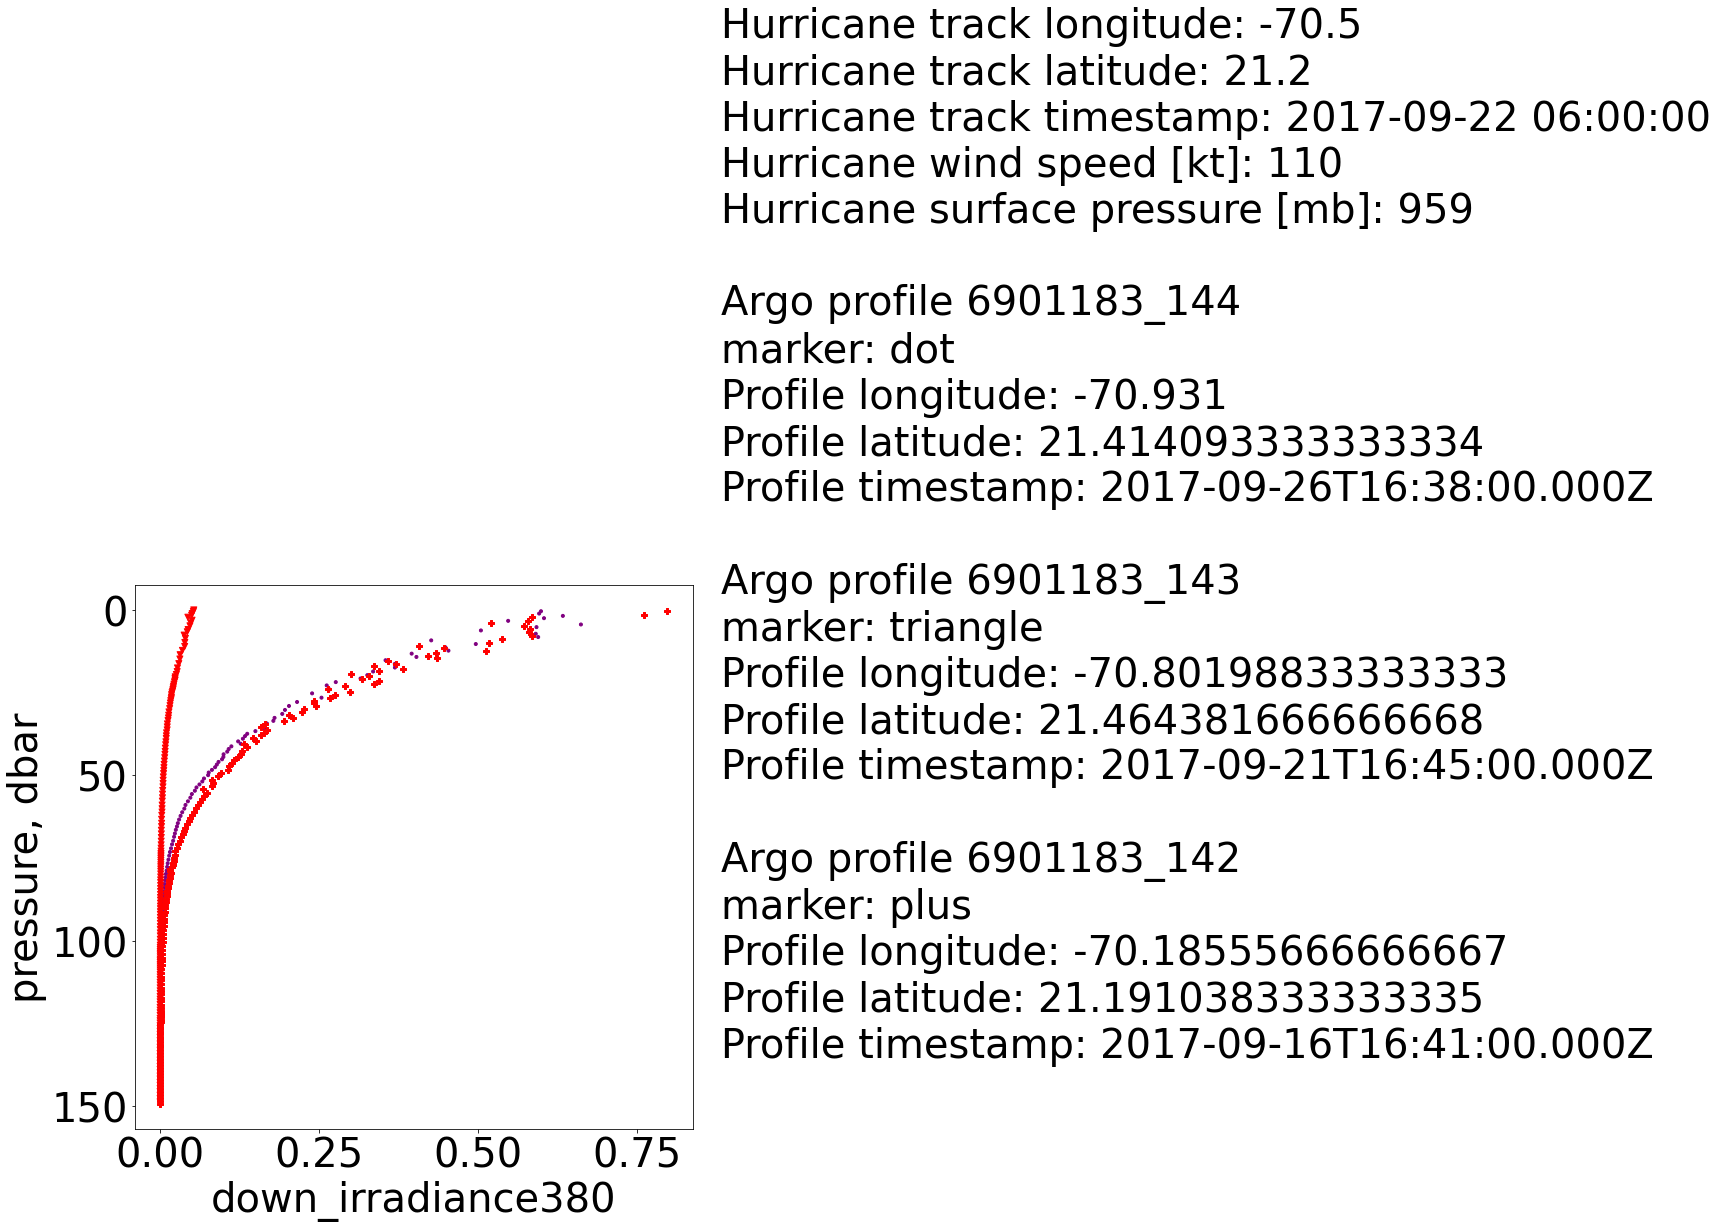

In [20]:
hurrplot([bracket_points[0]], 'down_irradiance380')

We can also colocate with a ship-based profile in a similar manner:

In [21]:
cruise_params = {
    "cchdo_cruise": 2370,
    "woceline": "AR07W"
}

cruise = avh.query('cchdo', options=cruise_params, apikey=API_KEY, apiroot=API_PREFIX)

In [22]:
colo_argo_bgc = []
for cchdo_meas in cruise:
    bgc_param = {
        "center": str(cchdo_meas['geolocation']['coordinates'][0]) + ',' + str(cchdo_meas['geolocation']['coordinates'][1]),
        "radius": 50,
        "startDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=-48))),
        "endDate": avh.parsetime((avh.parsetime(cchdo_meas['timestamp']) + timedelta(hours=+48))),
        "source": 'argo_bgc'
    }

    prox = avh.query('argo', options=bgc_param, apikey=API_KEY, apiroot=API_PREFIX)
    
    if len(prox) != 0:
        colo_argo_bgc.append(prox)

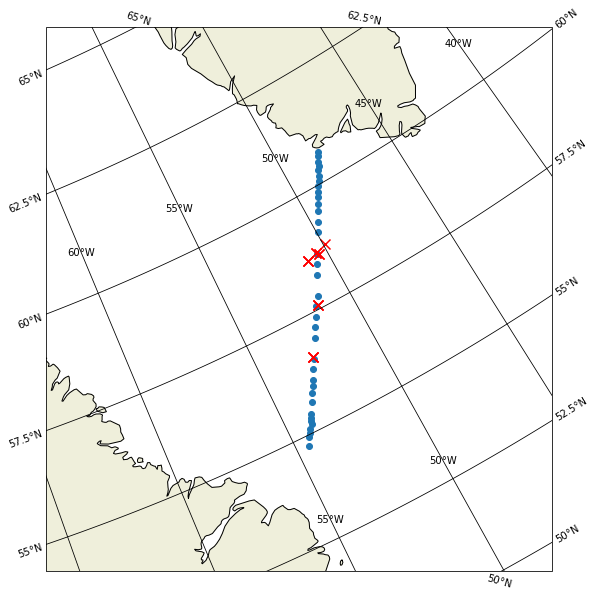

In [23]:
bgc_paths = []

for colo in colo_argo_bgc:
    bgc_paths.append({
        "lon": [x['geolocation']['coordinates'][0] for x in colo],
        "lat": [x['geolocation']['coordinates'][1] for x in colo]
    })
cchdo_longitudes = [x['geolocation']['coordinates'][0] for x in cruise]
cchdo_latitudes  = [x['geolocation']['coordinates'][1] for x in cruise]
simple_map(cchdo_longitudes,cchdo_latitudes, secondaries=bgc_paths, bounding_box=[-60,-45,53,63])
